In [1]:
import pandas as pd

# Load the sample data assuming it has no headers
df_sample = pd.read_csv('sample data.csv', header=None, names=['Username', 'Date', 'Message'])

# Check the first few rows of the loaded data
print(df_sample.head())

       Username   Date                                            Message
0  brightness04  6-Oct     "  kia hyundai under-achieving  "  kia hyun...
1     kdshapiro  6-Oct     "  kia hyundai most bmw's owners paid for t...
2     fedlawman  6-Oct     "  kia hyundai it's not a matter of   "  ki...
3      rockylee  6-Oct     "  kia hyundai under-achieving  "  kia hyun...
4      rockylee  6-Oct   i have 2 friends that own 3 series. i drove b...


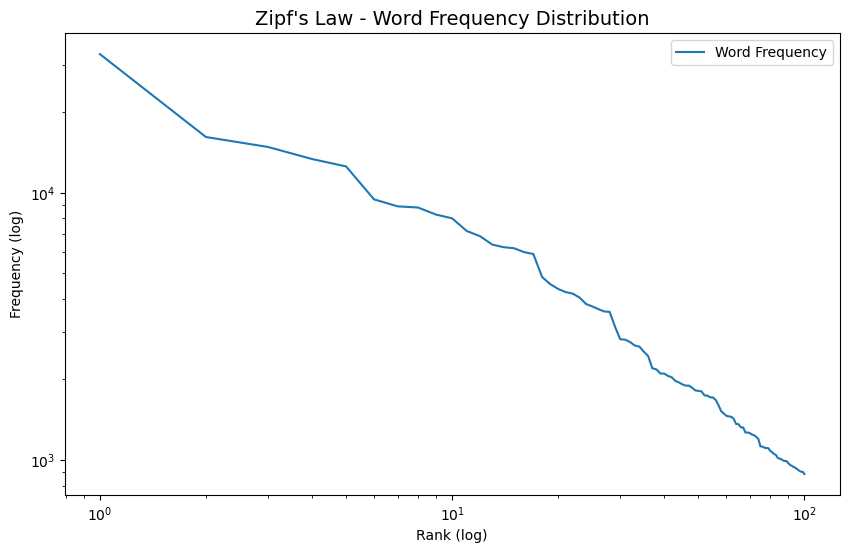

Slope: -0.8593232394592797
R-squared: 0.9772537166354572


In [2]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Concatenate all messages and split into words
all_text = ' '.join(df_sample['Message'].dropna())
words = re.findall(r'\w+', all_text.lower())
word_counts = Counter(words)

# Create a DataFrame of word frequencies
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Create the Zipf plot
word_freq_df = word_freq_df.reset_index(drop=True)
word_freq_df['rank'] = word_freq_df.index + 1
wf_100 = word_freq_df[:100]  # Focus on top 100 words

# Log-log plot for Zipf's law
plt.figure(figsize=(10, 6))
plt.plot(wf_100['rank'], wf_100['Frequency'], label='Word Frequency')
plt.xscale('log')
plt.yscale('log')
plt.title("Zipf's Law - Word Frequency Distribution", fontsize=14)
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.legend()
plt.show()

# Testing Zipf's law econometrically
log_rank = np.log(wf_100['rank'])
log_freq = np.log(wf_100['Frequency'])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(log_rank, log_freq)
print(f"Slope: {slope}")
print(f"R-squared: {r_value**2}")

In [3]:
from collections import defaultdict
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if you haven't already
# nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text (removes punctuation and stopwords)
def clean_text(text, stop_words):
    text = re.sub(r'\W+', ' ', text.lower())  # Remove punctuation and convert to lowercase
    words = text.split()
    return [word for word in words if word not in stop_words]

# Load car models and brands
df_models_brands = pd.read_csv("car_models_and_brands.csv")

# Filter out unwanted terms from brands
to_drop = ['car', 'seat', 'problem', 'sedan']
df_models_brands = df_models_brands[~df_models_brands['Brand'].isin(to_drop)]

car_brands = df_models_brands['Brand'].str.lower().unique()
model_to_brand = dict(zip(df_models_brands['Model'].str.lower(), df_models_brands['Brand'].str.lower()))

# Task B: Extract car brands from posts in sample data
def extract_brands(message, car_brands, model_to_brand, stop_words):
    # Clean and remove stopwords from message
    clean_message = ' '.join(clean_text(message, stop_words))
    
    # Find brands and models in the cleaned message
    found_brands = set([brand for brand in car_brands if brand in clean_message.lower()])
    found_models = [model for model in model_to_brand if model in clean_message.lower()]
    found_brands.update([model_to_brand[model] for model in found_models])
    
    return ', '.join(found_brands)

# Apply the brand extraction to the sample data
df_sample['Brands'] = df_sample['Message'].apply(lambda msg: extract_brands(msg, car_brands, model_to_brand, stop_words))

# Explode the Brands column to handle multiple brands in a single message
df_exploded = df_sample['Brands'].str.split(',').explode().str.strip()

# Filter out empty values
df_exploded = df_exploded[df_exploded != '']

# Calculate brand frequency counts
brand_counts = df_exploded.value_counts()

# Display the top 10 brands by frequency
top_10_brands = brand_counts.head(10)
print("Top 10 Brands by Frequency:")
print(top_10_brands)

Top 10 Brands by Frequency:
Brands
bmw              2044
hyundai          1794
kia              1712
toyota           1681
audi              845
acura             805
honda             716
pontiac           632
infiniti          555
mercedes-benz     312
Name: count, dtype: int64


In [4]:
# Task C: Lift Calculation
top_10_brands_list = top_10_brands.index.str.lower().tolist()

# Function to find brand co-occurrences within a window
def find_brand_pairs(message, brands, window=5):
    clean_message = ' '.join(clean_text(message, stop_words))  # Clean message with stopwords removed
    words = clean_message.split()
    brand_indices = {brand: [] for brand in brands}
    
    # Track the position of each brand in the message
    for i, word in enumerate(words):
        if word in brands:
            brand_indices[word].append(i)
    
    # Find pairs within the given window
    brand_pairs = set()
    for brand1, indices1 in brand_indices.items():
        for brand2, indices2 in brand_indices.items():
            if brand1 != brand2:
                for idx1 in indices1:
                    for idx2 in indices2:
                        if abs(idx1 - idx2)+1 <= window:
                            brand_pairs.add(tuple(sorted([brand1, brand2])))  # Ensure consistent order
    
    return brand_pairs

# Function to calculate word frequencies and word pair co-occurrences
def calculate_frequencies(df, brands, window=5):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))

    # Loop through each post and count word occurrences
    for index, row in df.iterrows():
        message = row['Message']
        clean_message = ' '.join(clean_text(message, stop_words))  # Clean text and remove stopwords
        brand_pairs = find_brand_pairs(clean_message, brands, window=window)

        # Update word frequencies
        for word in clean_message.split():
            if word in brands:
                word_frequency[word] += 1

        # Update pair frequencies
        for brand1, brand2 in brand_pairs:
            word_pair_frequency[brand1][brand2] += 1
            word_pair_frequency[brand2][brand1] += 1  # Update both directions

    return word_frequency, word_pair_frequency

# Function to calculate lift
def calculate_lift(word_frequency, word_pair_frequency, total_posts):
    lift_values = []

    for brand1, co_occurrences in word_pair_frequency.items():
        for brand2, count in co_occurrences.items():
            if brand1 != brand2:
                p_brand1 = word_frequency[brand1] / total_posts
                p_brand2 = word_frequency[brand2] / total_posts
                p_both = count / total_posts

                if p_brand1 * p_brand2 > 0:
                    lift = p_both / (p_brand1 * p_brand2)
                    lift_values.append({
                        'Brand 1': brand1,
                        'Brand 2': brand2,
                        'Lift': lift
                    })

    return pd.DataFrame(lift_values)

# Process data and compute lift values
total_posts = len(df_sample)
word_frequency, word_pair_frequency = calculate_frequencies(df_sample, top_10_brands_list, window=7)
lift_df = calculate_lift(word_frequency, word_pair_frequency, total_posts)

# Display the lift values table
print("\nLift Values Table:")
print(lift_df)


Lift Values Table:
    Brand 1   Brand 2      Lift
0   hyundai       kia  0.275393
1   hyundai       bmw  0.074705
2   hyundai    toyota  0.105997
3   hyundai     acura  0.085221
4   hyundai      audi  0.063879
..      ...       ...       ...
67    honda  infiniti  0.163285
68    honda       bmw  0.101253
69    honda   hyundai  0.103686
70    honda     acura  0.406737
71    honda       kia  0.092877

[72 rows x 3 columns]
